In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
from geopandas.tools import geocode

import re

from datetime import datetime

from shapely.geometry import LineString, MultiPolygon, Polygon
from shapely.ops import split
from shapely.affinity import translate

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

- df - информация об автомобилях 
    - num - номер региона
    - brand - бренд
    - model - модель авто
    - year - год выпуска
    - description - краткое описание
    - location - локация
    - price - цена
    
- salary - средняя ЗП в России за 2022 год по регионам
    - num - номер региона
    - region - название региона
    - median_salary - средняя ЗП (медиана)

In [3]:
df = pd.read_csv('data/auto_mers.csv')
salary = pd.read_csv('data/regions_with_salary.csv')

# https://www.kaggle.com/datasets/kapral42/russia-geo-data
rus_bnd_gdf = gpd.read_file('data/geo.json')

median_salary = salary.loc[0, 'median_salary']

In [4]:
salary[:4]

,region,median_salary,num,Region_en,NAME_1
0,Российская Федерация,62199.7,0,NaN,NaN
1,Белгородская область,46406.6,31,Belgorod region,Belgorod
2,Брянская область,39434.4,32,Bryansk region,Bryansk
3,Владимирская область,44136.4,33,Vladimir region,Vladimir


In [5]:
df[:4]

,num,brand,model,year,description,location,price
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",Майкоп,830000
1,1,Mercedes-Benz,Mercedes,1992,"2.3 л (136 л.с.), бензин, механика, задний, 22...",Майкоп,300000
2,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",Дондуковская,280000
3,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",Тахтамукай,200000


In [6]:
rus_bnd_gdf[:4]

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
0,186,RUS,Russia,28,Karachay-Cherkess,?????????-????????? ??????????,Karaçay-Çerkes|Karachay-Cherkessiya|Karachayev...,Respublika,Republic,"POLYGON ((42.13194 44.34488, 42.19061 44.32248..."
1,186,RUS,Russia,29,Karelia,?????????? ???????,Karelian A.S.S.R.|Karelo-Finnish A.S.S.R.|Kare...,Respublika,Republic,"MULTIPOLYGON (((36.77098 64.02402, 36.75969 64..."
2,186,RUS,Russia,30,Kemerovo,??????????? ???????,Kemerovskaya Oblast,Oblast,Region,"POLYGON ((88.63731 56.77809, 88.64615 56.73922..."
3,186,RUS,Russia,31,Khabarovsk,??????????? ????,Khabarovskiy Kray,Kray,Territory,"MULTIPOLYGON (((136.64362 45.04694, 136.64417 ..."


Удалим из датасета строки с моделью Mercedes

In [7]:
df = df[df.model != 'Mercedes']

In [8]:
df.shape

(26814, 7)

In [9]:
salary.shape

(154, 5)

Соединим таблицы (часть регионов отсутствует в salary) и добавим флаг того, больше ли средняя ЗП в данном регионе, чем средняя по России (брались медианы)

In [10]:
df = pd.merge(df, salary, on='num', how='inner')
df['flg_more_avg_salary'] = (df['median_salary'] > median_salary).astype(int)

In [11]:
df[:4]

,num,brand,model,year,description,location,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",Майкоп,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
1,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",Дондуковская,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
2,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",Тахтамукай,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0
3,1,Mercedes-Benz,C-Class,2011,"1.8 л (156 л.с.), бензин, АКПП, задний, 134 ты...",Майкоп,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0


In [12]:
df.shape

(26814, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26814 entries, 0 to 26813
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   num                  26814 non-null  int64  
 1   brand                26814 non-null  object 
 2   model                26814 non-null  object 
 3   year                 26814 non-null  int64  
 4   description          26814 non-null  object 
 5   location             26814 non-null  object 
 6   price                26814 non-null  int64  
 7   region               26814 non-null  object 
 8   median_salary        26814 non-null  float64
 9   Region_en            26814 non-null  object 
 10  NAME_1               26814 non-null  object 
 11  flg_more_avg_salary  26814 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 2.7+ MB


In [14]:
df.describe()

,num,year,price,median_salary,flg_more_avg_salary
count,26814.000000,26814.000000,2.681400e+04,26814.000000,26814.000000
mean,48.268703,2010.324457,2.826853e+06,59158.197285,0.272097
std,25.398777,8.173165,4.147156e+06,22507.835182,0.445048
min,1.000000,1940.000000,2.500000e+04,31348.600000,0.000000
25%,25.000000,2005.000000,7.950000e+05,44670.500000,0.000000
50%,50.000000,2012.000000,1.568950e+06,50292.800000,0.000000
75%,72.000000,2017.000000,3.190000e+06,62201.700000,1.000000
max,102.000000,2022.000000,9.500000e+07,136166.900000,1.000000


In [15]:
df.describe(include='object')

,brand,model,description,location,region,Region_en,NAME_1
count,26814,26814,26814,26814,26814,26814,26814
unique,1,41,10906,1236,82,82,82
top,Mercedes-Benz,E-Class,"2.9 л (330 л.с.), дизель, АКПП, 4WD",Москва,Москва,Moscow,Moscow City
freq,26814,6544,98,2130,2130,2130,2130


# Exploratory data analysis

## Feature Engineering

Проанализируем целевую переменную

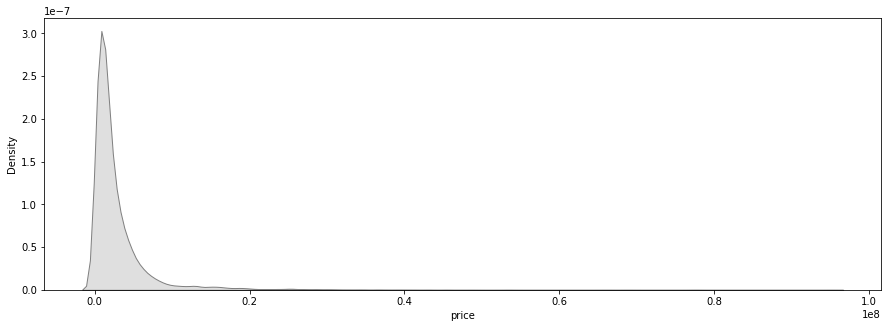

In [16]:
plt.figure(figsize=(15, 5))

sns.kdeplot(df['price'], fill=True, color='grey')
plt.show()

Видим явно большой хвост, при выборе функции потерь в модели ML это стоит учесть

Посмотрим на кол-во каждой модели в датасете

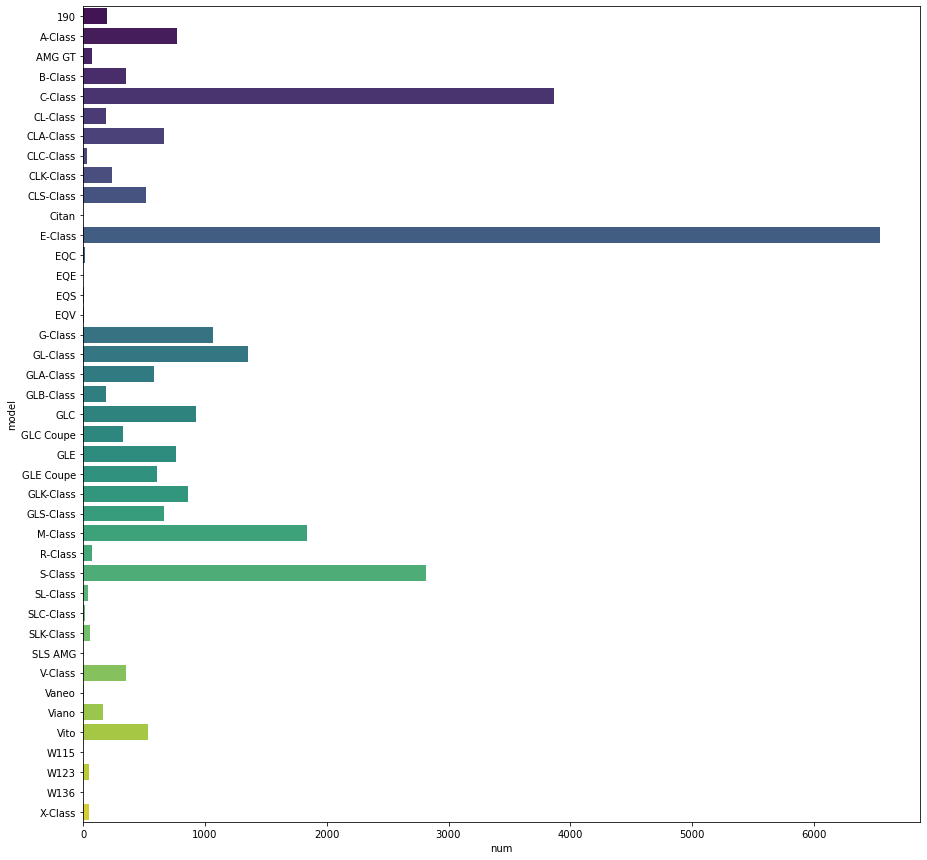

In [17]:
plt.figure(figsize=(15, 15))

sns.barplot(data=df.groupby('model')[['num']].count().reset_index(),
            y='model',
            x='num',
            palette='viridis')
plt.show()

Удалим модели, которых на продажу выставлено не так много

In [18]:
groups_count = df.groupby('model')['num'].count()
drop_models = groups_count[groups_count <= 15].index
df = df[~df.model.isin(drop_models)]

In [19]:
df.shape

(26769, 12)

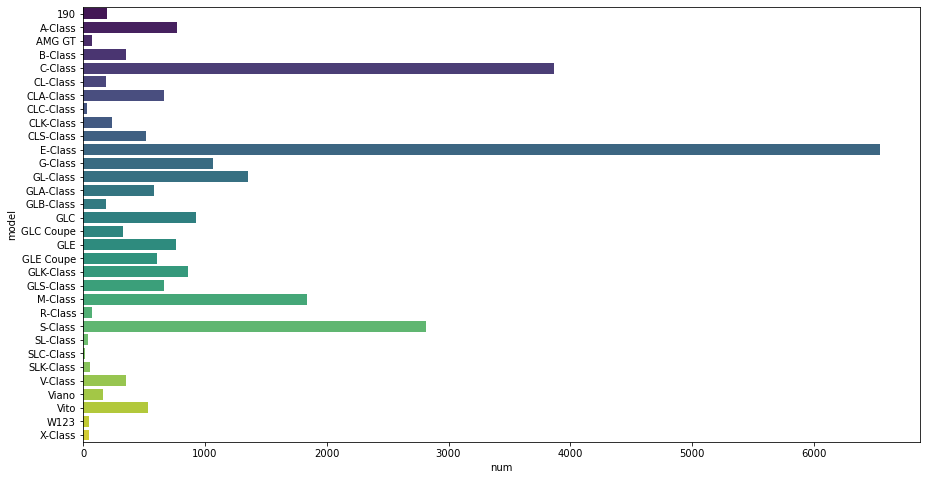

In [20]:
plt.figure(figsize=(15, 8))

sns.barplot(data=df.groupby('model')[['num']].count().reset_index(),
            y='model',
            x='num',
            palette='viridis')
plt.show()

Добавим признак возраст автомобиля

In [21]:
df['age'] = [datetime.now().year] - df['year'] 

Почистим некоторые из значений признаков

In [22]:
df[df.region == 'Республика Адыгея'].groupby('location')[['price']].median()

,price
location,
Апшеронск (≈ 50 км),950000.0
Белореченск (≈ 30 км),950000.0
Дондуковская,280000.0
Лабинск (≈ 60 км),1200000.0
Майкоп,1015000.0
Тахтамукай,300000.0
Хадыженск (≈ 70 км),600000.0
Ханская,1700000.0
Хатукай,250000.0


In [23]:
df[df.region == 'Республика Адыгея'].groupby('location')[['price']].count()

,price
location,
Апшеронск (≈ 50 км),2
Белореченск (≈ 30 км),27
Дондуковская,3
Лабинск (≈ 60 км),12
Майкоп,22
Тахтамукай,4
Хадыженск (≈ 70 км),5
Ханская,2
Хатукай,2


In [24]:
df.drop('location', axis=1, inplace=True)

Можно попробовать оставить только регион и убрать город, где продается автомобиль, чтобы у модели была большая обобщающая способность, так как данные не исторические, сложно сказать, что цена на автомобили в этом городе держится на таком уровне, также очень зависит от выставляемой модели на продажу 

In [26]:
df[:5]

,num,brand,model,year,description,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16
1,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23
2,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,31
3,1,Mercedes-Benz,C-Class,2011,"1.8 л (156 л.с.), бензин, АКПП, задний, 134 ты...",900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,11
4,1,Mercedes-Benz,A-Class,2000,"1.6 л (102 л.с.), бензин, механика, передний, ...",250000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,22


Преобразуем гео информацию для отображении на картах, также добавим среднюю зарплату

In [ ]:
# https://stackoverflow.com/questions/66833670/geopandas-map-centering-with-countries

In [27]:
def shift_geom(shift, row):
    shift -= 180
    moved_map = []
    splitted_map = []
    border = LineString([(shift, 90), (shift, -90)])

    splitted_map = split(row, border)
    items = list(splitted_map)

    for item in items:
        minx, miny, maxx, maxy = item.bounds
        if minx >= shift:
            moved_map.append(translate(item, xoff=-180 - shift))
        else:
            moved_map.append(translate(item, xoff=180 - shift))

    gdf = gpd.GeoDataFrame({"geometry": moved_map})
    return gdf.geometry.unary_union

In [28]:
rus_bnd_gdf['geometry'] = rus_bnd_gdf['geometry'].transform(
    lambda x: shift_geom(90, x))

In [29]:
russia_salary_geo = gpd.GeoDataFrame(
    pd.merge(salary,
             rus_bnd_gdf[['NAME_1', 'geometry']],
             on='NAME_1',
             how='left'))

In [30]:
russia_salary_geo[:2]

,region,median_salary,num,Region_en,NAME_1,geometry
0,Российская Федерация,62199.7,0,NaN,NaN,None
1,Белгородская область,46406.6,31,Belgorod region,Belgorod,"POLYGON ((-51.89174 51.38651, -51.85064 51.359..."


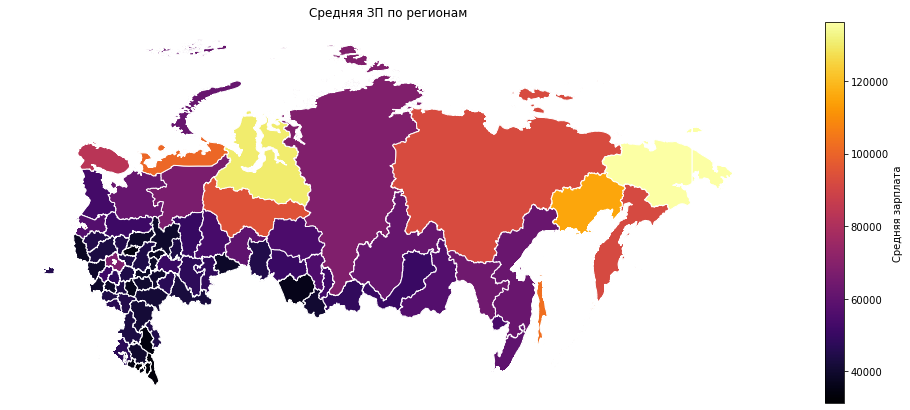

In [31]:
colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

mo_gdf_wm = russia_salary_geo.to_crs({'init':
                                      'epsg:4326'})  # преобразование проекции
mo_gdf_wm.plot(column='median_salary',
               linewidth=1,
               cmap=colors[2],
               legend=True,
               figsize=[20, 7],
               legend_kwds={
                   'label': "Средняя зарплата",
                   'orientation': "vertical"
               },
               edgecolor="white",
               aspect='auto')
plt.title('Средняя ЗП по регионам')
plt.axis('off')
plt.show()

> Наиболее высокие ЗП видим в северных и удаленных регионах, а также в Москве и Санкт-Петербурге 

Распарсим description по полям

In [32]:
def parsing_desc(data: str) -> list:
    try:
        # Если нет пробега
        if 'тыс. км' not in data:
            data += ', 0 тыс. км'

        lst = data.split(', ')
        ltr, type_engine, transm, machine_drive, mileage = lst[0], lst[1], lst[
            2], lst[3], lst[4]

        liters = float(ltr.split()[0])
        horsepower = int(re.sub(r"[^\d]", '', ltr.split()[2]))
        mileage = int(re.sub(r"[^\d]", '', mileage))
        mileage = 0 if mileage == 1 else mileage
        
        return [
            liters, horsepower, type_engine, transm, machine_drive, mileage
        ]
    except:
        return None

In [33]:
df['full_desc'] = df['description'].transform(lambda x: parsing_desc(x))

In [34]:
df[:3]

,num,brand,model,year,description,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,full_desc
0,1,Mercedes-Benz,E-Class,2006,"3.2 л (204 л.с.), дизель, АКПП, задний, 350 ты...",830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,"[3.2, 204, дизель, АКПП, задний, 350]"
1,1,Mercedes-Benz,E-Class,1999,"2.8 л (193 л.с.), бензин, автомат, задний, 360...",280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23,"[2.8, 193, бензин, автомат, задний, 360]"
2,1,Mercedes-Benz,E-Class,1991,"3.0 л (220 л.с.), бензин, АКПП, задний, 352 ты...",200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,31,"[3.0, 220, бензин, АКПП, задний, 352]"


In [35]:
df_parse = df["full_desc"].apply(pd.Series)
df_parse.columns = [
    'liters', 'horse_power', 'type_engine', 'transmission', 'machine_drive',
    'mileage'
]

df = pd.concat([df.drop(['description', 'full_desc'], axis=1), df_parse],
               axis=1)

In [36]:
df[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,3.2,204.0,дизель,АКПП,задний,350.0
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23,2.8,193.0,бензин,автомат,задний,360.0
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,31,3.0,220.0,бензин,АКПП,задний,352.0
3,1,Mercedes-Benz,C-Class,2011,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,11,1.8,156.0,бензин,АКПП,задний,134.0


In [37]:
df[(df.mileage == 0) & (df.age > 2)][:5]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
23,1,Mercedes-Benz,E-Class,1993,500000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,29,3.0,136.0,дизель,механика,задний,0.0
32,1,Mercedes-Benz,CLK-Class,2002,600000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,20,2.6,170.0,бензин,АКПП,задний,0.0
61,1,Mercedes-Benz,E-Class,1993,500000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,29,3.0,136.0,дизель,механика,задний,0.0
69,1,Mercedes-Benz,CLK-Class,2002,600000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,20,2.6,170.0,бензин,АКПП,задний,0.0
83,1,Mercedes-Benz,E-Class,1993,550000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,29,3.0,136.0,дизель,механика,задний,0.0


In [38]:
df[(df.mileage < 2) & (df.age > 2)][:3]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
23,1,Mercedes-Benz,E-Class,1993,500000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,29,3.0,136.0,дизель,механика,задний,0.0
32,1,Mercedes-Benz,CLK-Class,2002,600000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,20,2.6,170.0,бензин,АКПП,задний,0.0
61,1,Mercedes-Benz,E-Class,1993,500000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,29,3.0,136.0,дизель,механика,задний,0.0


Скорее всего в данных объявлениях забыли указать пробег, поэтому для чистоты эксперимента лучше удалить такие данные

In [39]:
index_drop = df[(df.mileage < 2) & (df.age > 2)].index
df = df[~df.index.isin(index_drop)]

In [40]:
df.isna().sum()

num                      0
brand                    0
model                    0
year                     0
price                    0
region                   0
median_salary            0
Region_en                0
NAME_1                   0
flg_more_avg_salary      0
age                      0
liters                 273
horse_power            273
type_engine            273
transmission           273
machine_drive          273
mileage                273
dtype: int64

In [41]:
df.describe()

,num,year,price,median_salary,flg_more_avg_salary,age,liters,horse_power,mileage
count,26144.000000,26144.000000,2.614400e+04,26144.000000,26144.000000,26144.000000,25871.000000,25871.000000,25871.000000
mean,48.548080,2010.479995,2.852815e+06,59377.822020,0.275551,11.520005,2.776835,236.897569,164.513123
std,25.316283,8.090246,4.120743e+06,22538.278198,0.446800,8.090246,1.134794,102.423437,115.804521
min,1.000000,1960.000000,2.500000e+04,31348.600000,0.000000,0.000000,0.400000,38.000000,0.000000
25%,25.000000,2006.000000,8.000000e+05,45025.700000,0.000000,5.000000,2.000000,163.000000,78.000000
50%,50.000000,2012.000000,1.600000e+06,50292.800000,0.000000,10.000000,2.300000,211.000000,150.000000
75%,72.000000,2017.000000,3.200000e+06,63730.800000,1.000000,16.000000,3.200000,272.000000,230.000000
max,102.000000,2022.000000,7.760700e+07,136166.900000,1.000000,62.000000,6.500000,700.000000,1000.000000


In [42]:
df.describe(include='object')

,brand,model,region,Region_en,NAME_1,type_engine,transmission,machine_drive
count,26144,26144,26144,26144,26144,25871,25871,25871
unique,1,32,82,82,82,3,5,3
top,Mercedes-Benz,E-Class,Москва,Moscow,Moscow City,бензин,АКПП,4WD
freq,26144,6323,2108,2108,2108,19363,20313,13122


In [43]:
df[df.liters < 1.0]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
8118,25,Mercedes-Benz,S-Class,2007,1700000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,15,0.5,388.0,бензин,автомат,4WD,10.0
22965,77,Mercedes-Benz,G-Class,2022,23000000,Москва,114700.7,Moscow,Moscow City,1,0,0.4,422.0,бензин,автомат,4WD,0.0


In [44]:
df.query("model.str.contains('S-Class') and year==2007 and horse_power==388",
         engine="python")[:2]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
25,1,Mercedes-Benz,S-Class,2007,1050000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,15,5.5,388.0,бензин,АКПП,4WD,184.0
63,1,Mercedes-Benz,S-Class,2007,1050000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,15,5.5,388.0,бензин,АКПП,4WD,184.0


In [45]:
df.query("model.str.contains('G-Class') and year==2022",
         engine="python")[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage
5615,23,Mercedes-Benz,G-Class,2022,27900000,Краснодарский край,47231.8,Krasnodar region,Krasnodar,0,0,4.0,585.0,бензин,АКПП,4WD,0.0
7223,25,Mercedes-Benz,G-Class,2022,27000000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,0,4.0,585.0,бензин,АКПП,4WD,0.0
7305,25,Mercedes-Benz,G-Class,2022,26500000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,0,4.0,585.0,бензин,АКПП,4WD,0.0
7349,25,Mercedes-Benz,G-Class,2022,27000000,Приморский край,59689.6,Primorsky Krai,Primor'ye,0,0,4.0,585.0,бензин,АКПП,4WD,0.0


In [46]:
df.loc[8118, 'liters'] = 5.5
df.loc[22965, 'liters'] = 4.0

Видим пропуски, давайте заполним их похожими значениями

In [47]:
for col in [
        'liters', 'horse_power', 'type_engine', 'transmission',
        'machine_drive', 'mileage'
]:
    df[col] = df.groupby(
        ['model',
         'year'])[col].apply(lambda x: x.fillna(x.mode(dropna=False)[0]))

In [48]:
df.isna().sum()

num                     0
brand                   0
model                   0
year                    0
price                   0
region                  0
median_salary           0
Region_en               0
NAME_1                  0
flg_more_avg_salary     0
age                     0
liters                  8
horse_power             8
type_engine             8
transmission            8
machine_drive           8
mileage                61
dtype: int64

In [49]:
df.dropna(inplace=True)

In [50]:
df.shape

(26083, 17)

Добавим флаг того, что это новый автомобиль

In [51]:
df['flg_new_auto'] = (df.mileage == 0).astype(int)

In [52]:
df['flg_new_auto'].value_counts()

0    24926
1     1157
Name: flg_new_auto, dtype: int64

Проверим еще типы коробок передач

In [53]:
df.transmission.value_counts()

АКПП        20486
робот        1931
механика     1820
автомат      1596
вариатор      250
Name: transmission, dtype: int64

АКПП в целом довольно общее понятие, для простоты заменим его на автомат

In [54]:
df['transmission'] = df['transmission'].replace('АКПП', 'автомат')

In [55]:
df.transmission.value_counts()

автомат     22082
робот        1931
механика     1820
вариатор      250
Name: transmission, dtype: int64

Добавим новый признак тип кузова

In [56]:
body_type = {
    'Хэтчбэк': ['A-Class', 'B-Class'],
    'Седан': ['E-Class', 'C-Class', 'S-Class', '190', 'W123'],
    'Внедорожники': [
        'X-Class', 'M-Class', 'GLC', 'GLA-Class', 'GLB-Class', 'GLS-Class',
        'GLE', 'GL-Class', 'GLK-Class', 'G-Class'
    ],
    'Купэ': ['CLA-Class', 'CLS-Class', 'AMG GT', 'CL-Class', 'CLC-Class'],
    'Родстеры/кабриолеты': ['SL-Class', 'SLC-Class', 'CLK-Class', 'SLK-Class'],
    'Минивэн': ['Vito', 'Viano', 'V-Class', 'R-Class'],
    'Кроссовер': ['GLE Coupe', 'GLC Coupe'],
}

reverse_body_type = {x: k for k, v in body_type.items() for x in v}

In [57]:
df['body_type'] = df.model.map(reverse_body_type)

In [58]:
df[:4]

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,flg_new_auto,body_type
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,16,3.2,204.0,дизель,автомат,задний,350.0,0,Седан
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23,2.8,193.0,бензин,автомат,задний,360.0,0,Седан
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,31,3.0,220.0,бензин,автомат,задний,352.0,0,Седан
3,1,Mercedes-Benz,C-Class,2011,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,11,1.8,156.0,бензин,автомат,задний,134.0,0,Седан


In [59]:
def plot_auto_geo(data: pd.DataFrame,
                  geo_data: gpd.GeoDataFrame,
                  title: str,
                  cmap: str = 'Spectral_r',
                  agg_col: str = 'price',
                  func: str = 'mean',
                  group_col: str = 'NAME_1',
                  ax=None):
    """Отображение на карте агрегированных данных"""

    agg_data = data.groupby(group_col)[agg_col].agg(func)
    auto_geo = gpd.GeoDataFrame(
        pd.merge(agg_data, geo_data, on=group_col, how='left'))

    mo_gdf_wm = auto_geo.to_crs({'init': 'epsg:4326'})
    mo_gdf_wm.plot(column=agg_col,
                   linewidth=0.5,
                   cmap=cmap,
                   legend=True,
                   figsize=[20, 7],
                   legend_kwds={
                       'label': func,
                       'orientation': "vertical"
                   },
                   edgecolor="white",
                   vmin=agg_data.min(),
                   vmax=agg_data.max(),
                   ax=ax,
                   aspect='auto')
    if ax:
        ax.set_title(title, fontdict={'fontsize': 14})
    else:
        plt.title(title, fontdict={'fontsize': 16})
        plt.axis('off')
        plt.show()

## Гипотезы
### В регионах с ЗП выше средней по России цена на автомобиль выше

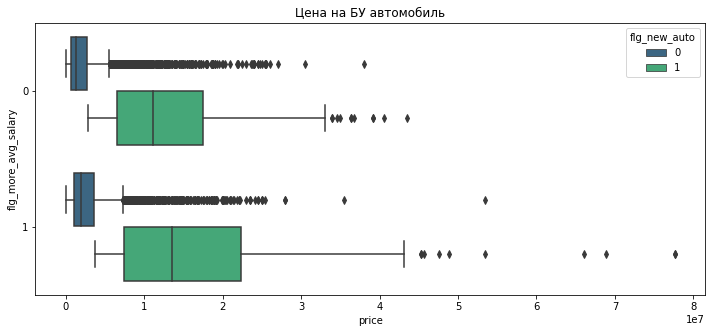

In [60]:
plt.figure(figsize=(12, 5))

sns.boxplot(data=df,
            x='price',
            y='flg_more_avg_salary',
            hue='flg_new_auto',
            orient="h",
            palette='viridis')
plt.title('Цена на БУ автомобиль')
plt.show()

> Видим, ориентируясь по медианам, что чуть более высокую цену порядка на 500 тыс рублей в регионах с ЗП выше среднего (около 30%), также если посмотреть на концы усов, увидим аналогичную ситуацию, причем начальная цена стартует почти из одной и той же точки.

### Цена машины коррелирует со средней зарплатой в регионе

Посмотрим на корреляцию между данными признаками, заодно глянет и на другие

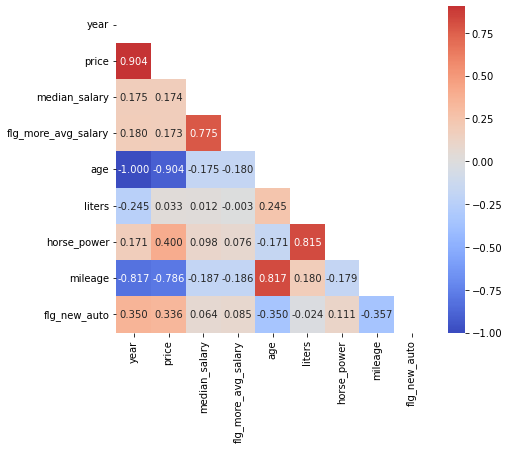

In [61]:
matrix = np.triu(df.iloc[:, 1:].corr(method='spearman'))

plt.figure(figsize=(7, 6))

sns.heatmap(df.iloc[:, 1:].corr(method='spearman'),
            annot=True,
            fmt='.3f',
            center=0,
            cmap='coolwarm',
            mask=matrix)
plt.show()

> Единственное, что можно сказать, это то, что цена коррелирует с годом (чем новее машина, тем дороже)

> А также то, что чем больше пробег, тем меньше цена. Но данные выводы всем и так известны, поэтому отдельно их рассматривать нет смысла

### Есть различия в цене в разрезе значений типа двигателя, коробки передач, трансмиссии, конструкции трансмиссии

Довольно также интуиитивно понятная гипотеза как и с пробегом и годом, но давайте все же посмотрим на практике

In [62]:
price_df = df[['type_engine', 'transmission', 'machine_drive',
               'price']].melt(id_vars=['price'])

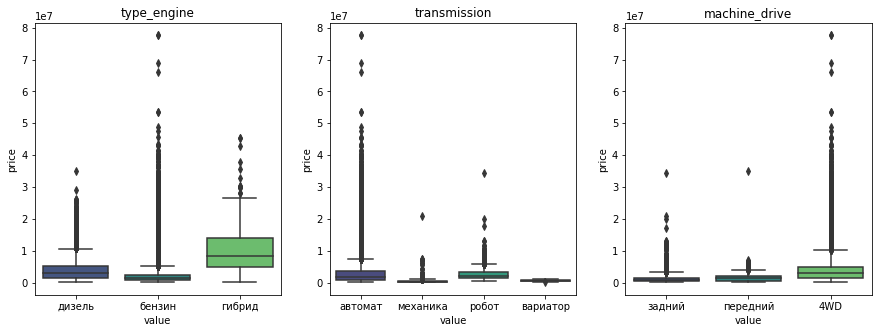

In [63]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for num, val in enumerate(price_df.variable.unique()):
    sns.boxplot(data=price_df[price_df.variable == val],
                y='price',
                x='value',
                palette=colors[0],
                ax=axes[num]).set_title(val)

plt.show()

> Гибрид самый дорогой

> автомат и робот также самые дорогие

> полноприводные более дорогии

### Цена на автомобили выше в регионах со средней ЗП выше средней по стране

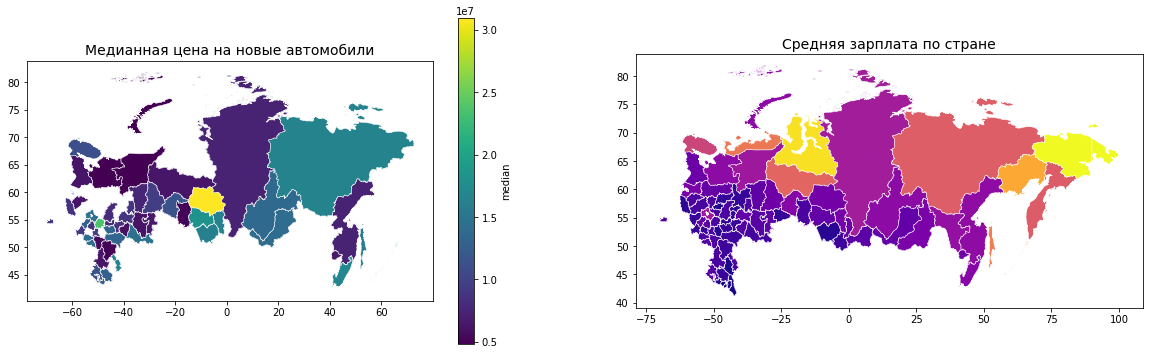

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

plot_auto_geo(data=df[df.flg_new_auto == 1],
              geo_data=russia_salary_geo,
              title='Медианная цена на новые автомобили',
              cmap=colors[0],
              agg_col='price',
              func='median',
              group_col='NAME_1',
              ax=axes[0])

mo_gdf_wm = russia_salary_geo.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='median_salary',
               linewidth=0.5,
               cmap=colors[1],
               legend_kwds={
                   'label': "median salary",
                   'orientation': "vertical"
               },
               edgecolor="white",
               ax=axes[1],
               aspect='auto')
axes[1].set_title('Средняя зарплата по стране', fontdict={'fontsize': 14})
plt.show()

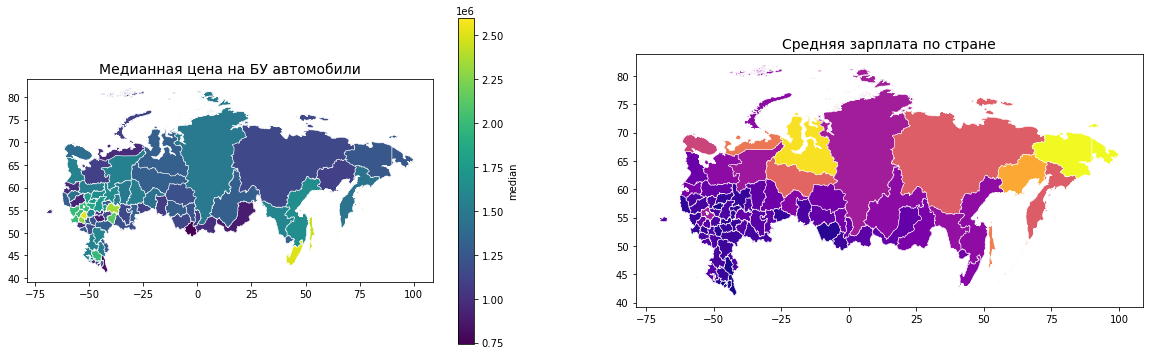

In [68]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

plot_auto_geo(data=df[df.flg_new_auto == 0],
              geo_data=russia_salary_geo,
              title='Медианная цена на БУ автомобили',
              cmap=colors[0],
              agg_col='price',
              func='median',
              group_col='NAME_1',
              ax=axes[0])

mo_gdf_wm = russia_salary_geo.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='median_salary',
               linewidth=0.5,
               cmap=colors[1],
               legend_kwds={
                   'label': "median salary",
                   'orientation': "vertical"
               },
               edgecolor="white",
               ax=axes[1],
               aspect='auto')
axes[1].set_title('Средняя зарплата по стране', fontdict={'fontsize': 14})
plt.show()

> Нет никакой корреляции как для БУ, так и для новых автомобилей

### Кол-во новых автомобилей выше в регионах со средней ЗП выше средней по стране

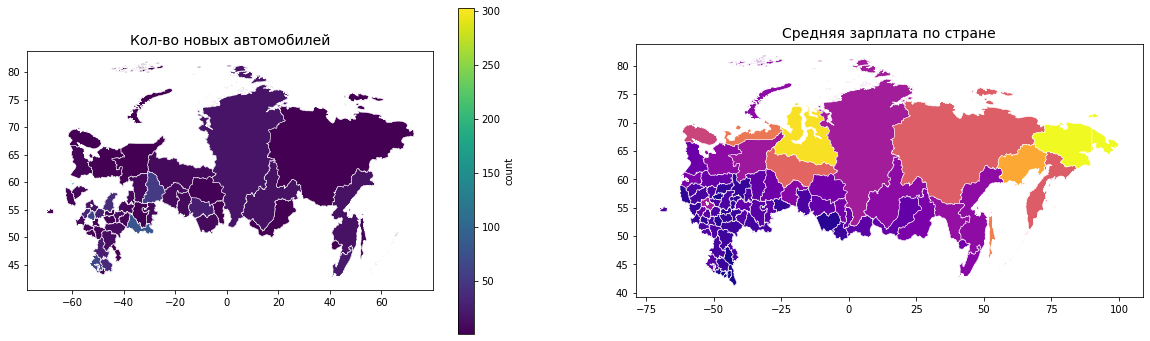

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

plot_auto_geo(data=df[df.flg_new_auto == 1],
              geo_data=russia_salary_geo,
              title='Кол-во новых автомобилей',
              cmap=colors[0],
              agg_col='price',
              func='count',
              group_col='NAME_1',
              ax=axes[0])

mo_gdf_wm = russia_salary_geo.to_crs({'init': 'epsg:4326'})
min_sal = russia_salary_geo.median_salary.min()
max_sal = russia_salary_geo.median_salary.max()
mo_gdf_wm.plot(column='median_salary',
               linewidth=0.5,
               cmap=colors[1],
               legend_kwds={
                   'label': "median salary",
                   'orientation': "vertical"
               },
               edgecolor="white",
               vmin=min_sal,
               vmax=max_sal,
               ax=axes[1],
               aspect='auto')
axes[1].set_title('Средняя зарплата по стране', fontdict={'fontsize': 14})
plt.show()

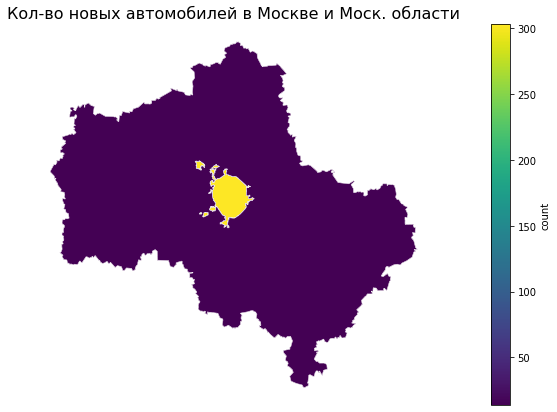

In [70]:
plot_auto_geo(data=df[(df.flg_new_auto == 1)
                      & (df.region.str.contains('Моск'))],
              geo_data=russia_salary_geo,
              title='Кол-во новых автомобилей в Москве и Моск. области',
              cmap=colors[0],
              agg_col='price',
              func='count',
              group_col='NAME_1')

> Больше всего новых автомобилей продается на приграничных регионах, которые ближе всего к Центральной части страны, а также в самой Москве, Санкт-Петербурге, корреляции с ЗП также не наблюдается

### Тип кузова влияет на значение цены

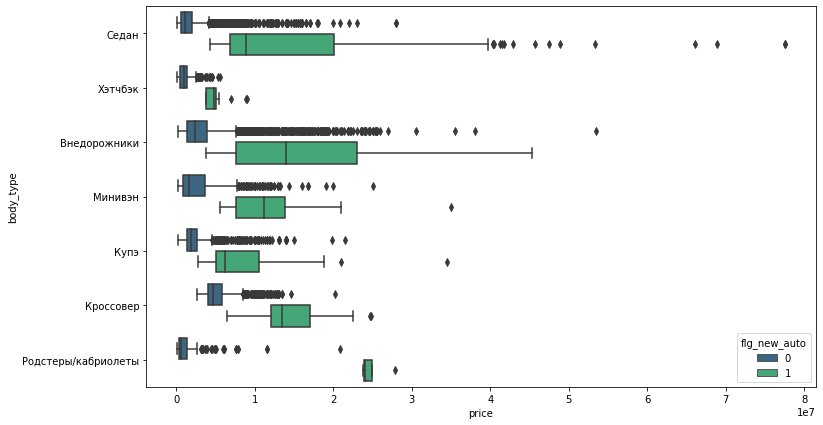

In [71]:
plt.figure(figsize=(12, 7))

sns.boxplot(data=df,
            x='price',
            hue='flg_new_auto',
            y='body_type',
            palette=colors[0],
            orient='h')
plt.show()

> Большой достаточно разброс значений у седана, так как S-класс стоят дороже, чем некоторые внедорожники

> Самые дешевые это кабриолеты/родстеры (связано с тем, большой средний возраст авто) и хэтчбеки, самые дорогие - кроссоверы

> Можно отметить по соотношению кол-ва лет-цена, хэтчбэки по-сравнению с остальными типами наиболее дешевые

### Больше всего БУ авто в Центральном регионе страны

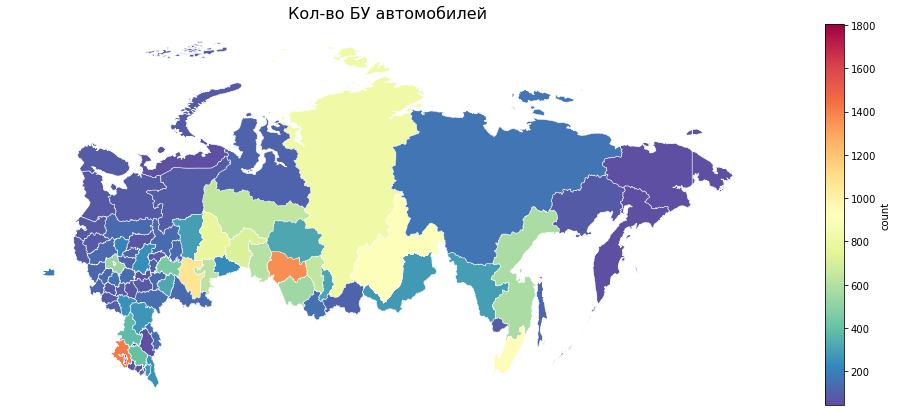

In [72]:
plot_auto_geo(data=df[df.flg_new_auto == 0],
              geo_data=russia_salary_geo,
              title='Кол-во БУ автомобилей',
              agg_col='price',
              func='count',
              group_col='NAME_1')
plt.show()

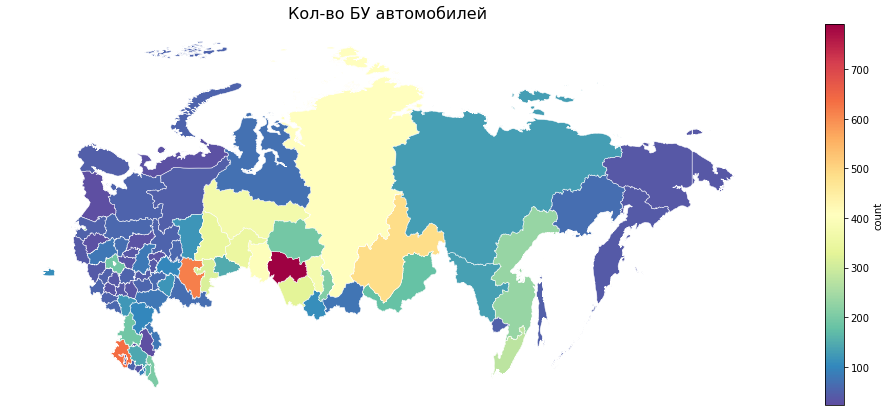

In [73]:
plot_auto_geo(data=df[(df.age > 10) & (df.age < 30)],
              geo_data=russia_salary_geo,
              title='Кол-во БУ автомобилей',
              agg_col='price',
              func='count',
              group_col='NAME_1')
plt.show()

> Больше всего продается БУ авто в Москве, Астраханской области, Новосибирской области, а также Башкортостане

### Цена на БУ авто ниже в регионах из выводов предыдущей гипотезы

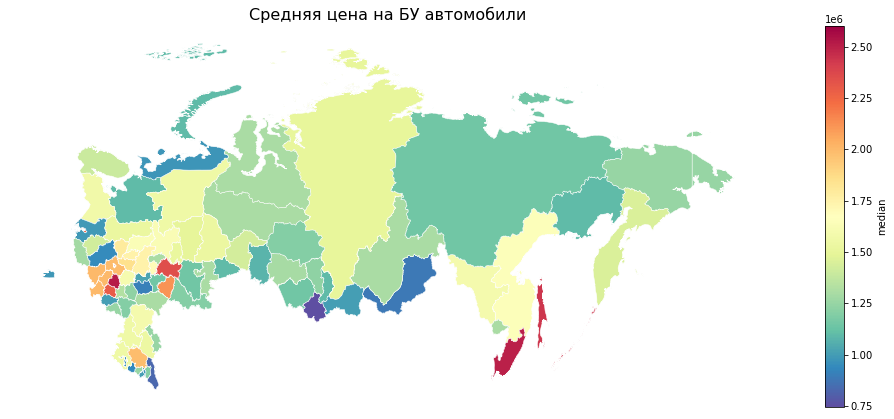

In [74]:
plot_auto_geo(data=df[df.flg_new_auto == 0],
              geo_data=russia_salary_geo,
              title='Средняя цена на БУ автомобили',
              agg_col='price',
              func='median',
              group_col='NAME_1')
plt.show()

> В данных регионах наблюдается средняя и высокие цены

### Дополнительно

Давайте посмотрим, насколько в % падают в цене автомобили по типу кузова

In [75]:
df_pivot_diff = df[df.flg_new_auto == 0].pivot_table(values='price',
                                                     index='body_type',
                                                     columns='age',
                                                     aggfunc='median')
df_pivot_diff = df_pivot_diff.iloc[:, :5].dropna()
df_pivot_diff['price_new_auto'] = df[df.flg_new_auto == 1].groupby(
    'body_type')['price'].median()

for i in range(5):
    df_pivot_diff[f'diff_{i+1}_year'] = (
        df_pivot_diff['price_new_auto'] -
        df_pivot_diff[i]) / df_pivot_diff['price_new_auto']

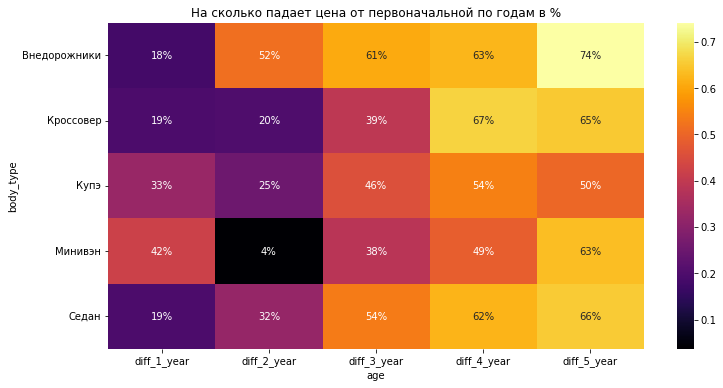

In [76]:
plt.figure(figsize=(12, 6))

ax = sns.heatmap(df_pivot_diff.loc[:, 'diff_1_year':],
            cmap=colors[2],
            annot=True,
            fmt='.0%')
plt.title('На сколько падает цена от первоначальной по годам в %')
plt.show()

> Самое большое падение цены наблюдается у минивэнов, а также у купэ

> Начиная со 2го года эксплуатации в цене сильно падают внедорожники

Проанализируем, какие типы кузова чаще всего покупают в тех или иных регионах

In [77]:
# Относительно всех автомобилей в регионе
# считаем кол-во каждого типа кузова в регионах
df_count_region = df.pivot_table(values='price',
                                 index='body_type',
                                 columns='region',
                                 aggfunc='count').fillna(0)
# нормируем на кол-во машин в регионе
df_norm_region = df_count_region / df.groupby('region').count().iloc[:, 0]
df_max_region = df_norm_region.idxmax().reset_index().rename(
    columns={0: 'body_type'})

# объединяем с гео данными
gpd_region_max = gpd.GeoDataFrame(
    pd.merge(russia_salary_geo, df_max_region, how='inner', on='region'))

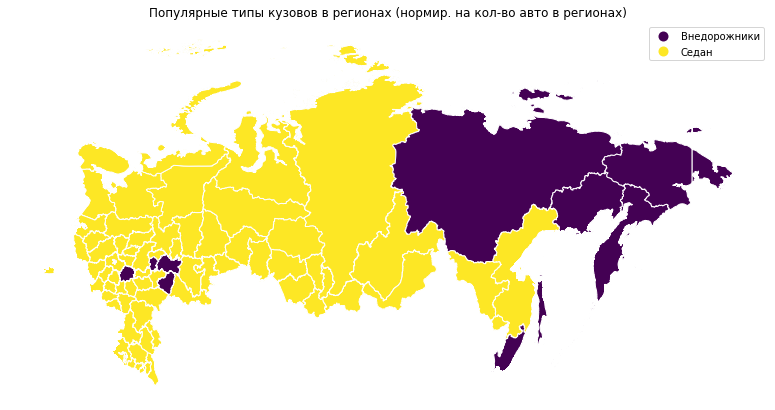

In [78]:
colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

mo_gdf_wm = gpd_region_max.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[0],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во авто в регионах)')
plt.axis('off')
plt.show()

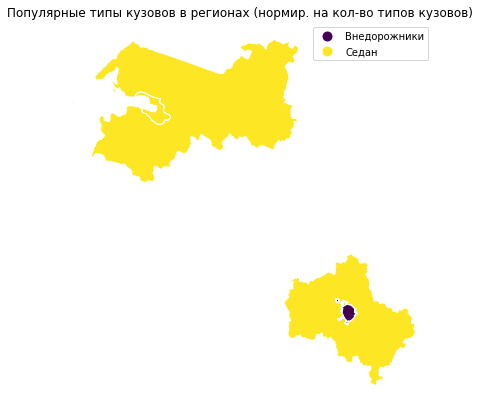

In [79]:
searchfor = ['Санкт', 'Лен', 'Моск']
mo_gdf_wm = gpd_region_max[gpd_region_max.region.str.contains(
    '|'.join(searchfor))].to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[0],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во типов кузовов)')
plt.axis('off')
plt.show()

> Больше всего популярны внедорожники на востоке страны, а также в некоторых центральных частях страны, особенно в Москве

In [80]:
# Относительно кол-ва продаваемых типов кузовов
# нормируем на кол-во типов кузовов
df_norm_region = df_count_region.T / df.groupby('body_type').count().iloc[:, 0]
df_max_region = df_norm_region.T.idxmax().reset_index().rename(
    columns={0: 'body_type'})

# объединяем с гео данными
gpd_body_max = gpd.GeoDataFrame(
    pd.merge(russia_salary_geo, df_max_region, how='inner', on='region'))

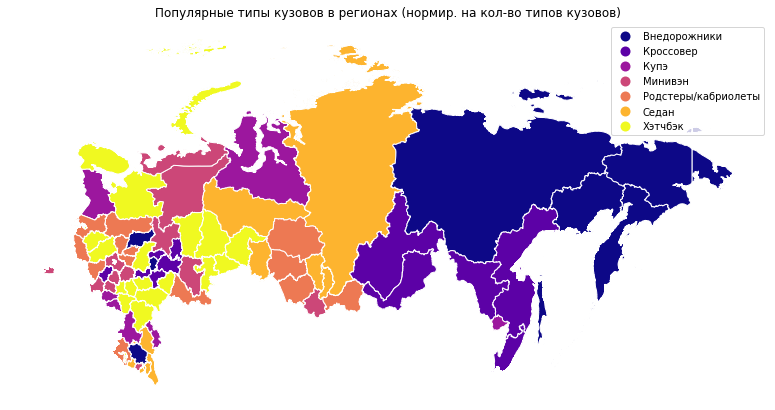

In [81]:
colors = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

mo_gdf_wm = gpd_body_max.to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[1],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во типов кузовов)')
plt.axis('off')
plt.show()

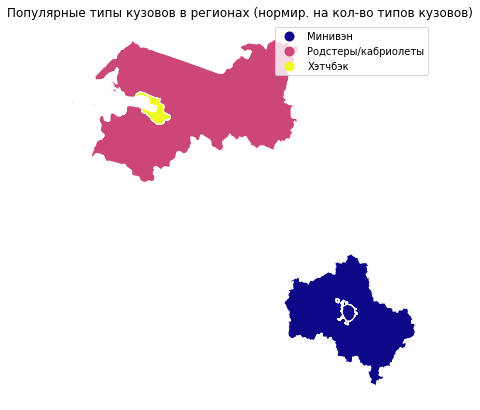

In [83]:
searchfor = ['Санкт', 'Лен', 'Моск']
mo_gdf_wm = gpd_body_max[gpd_body_max.region.str.contains(
    '|'.join(searchfor))].to_crs({'init': 'epsg:4326'})
mo_gdf_wm.plot(column='body_type',
               linewidth=1,
               cmap=colors[1],
               legend=True,
               figsize=[20, 7],
               edgecolor="white",
               aspect='auto')
plt.title(
    'Популярные типы кузовов в регионах (нормир. на кол-во типов кузовов)')
plt.axis('off')
plt.show()

> Внедорожники все также популярны на востоке страны

> В Москве также предпочитают больше минивэны, в Санкт-Петербурге - хэтчбеки

In [84]:
df.to_csv('data/clean_full_dataset.csv', index=0)